# Explore the dataset


In this notebook, we will perform an EDA (Exploratory Data Analysis) on the processed Waymo dataset (data in the `processed` folder). In the first part, you will create a function to display 

In [22]:
from utils import get_dataset
import glob
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import tensorflow as tf

%matplotlib inline

# Color for classes
# 1: Vehicle - red
# 2: Cyclist - green
# 3: Predestrian - blue
CLASS_COLOR = {
    1: "r",
    2: "g",
    3: "b"
}

In [2]:
# Get data_set using the utility method
dataSet = get_dataset("data/train/*.tfrecord")

INFO:tensorflow:Reading unweighted datasets: ['data/train/*.tfrecord']
INFO:tensorflow:Reading record datasets for input file: ['data/train/*.tfrecord']
INFO:tensorflow:Number of filenames to read: 86
Instructions for updating:
Use `tf.data.Dataset.interleave(map_func, cycle_length, block_length, num_parallel_calls=tf.data.experimental.AUTOTUNE)` instead. If sloppy execution is desired, use `tf.data.Options.experimental_deterministic`.
Instructions for updating:
Use `tf.data.Dataset.map()


## Write a function to display an image and the bounding boxes

Implement the `display_images` function below. This function takes a batch as an input and display an image with its corresponding bounding boxes. The only requirement is that the classes should be color coded (eg, vehicles in red, pedestrians in blue, cyclist in green).

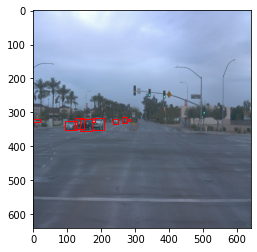

In [37]:
# Create figure
fig = plt.figure()

# Access data inside the data_set by iterating over the data_set
for index, data in enumerate(dataSet):
    
    # Display onle 1 image and break
    if index == 0:
        display_images(data)
        break


In [32]:
def display_images(batch):
    # Store image in local variable
    image = batch["image"]
    
    # Save bounding box of current element in local variable
    gtBoxes = batch["groundtruth_boxes"]
    
    # Save labels in local variable
    gtClasses = batch["groundtruth_classes"]
    
    # Save image shape
    height = image.shape[0]
    width = image.shape[1]
    
    # Iterate over both classes and boxes. Use the zip method to get pairs of (class, box)
    for gtClass, gtBox in zip(gtClasses, gtBoxes):
        # Get normalized box coordinates. Use numpy() method to convert tensor to array
        y1, x1, y2, x2 = gtBox.numpy()
        
        # Get class as numpy array
        gtClassNP = gtClass.numpy()
        
        # Resize box coordinates to image size. Use height for y and width for x values
        y1 *= height
        y2 *= height
        x1 *= width
        x2 *= width
        
        # Create the rectangel to be plotted
        rectangle = patches.Rectangle((x1, y1),
                                      x2-x1,
                                      y2-y1,
                                      facecolor="none",
                                      edgecolor=CLASS_COLOR[gtClassNP])
        
        # Add rectangel to current axis
        plt.gca().add_patch(rectangle)
    
    # Display image
    plt.imshow(image)
    plt.show()
    
    pass

## Display 10 images 

Using the dataset created in the second cell and the function you just coded, display 10 random images with the associated bounding boxes. You can use the methods `take` and `shuffle` on the dataset.

In [36]:
# Display 10 random images in dataset





## Additional EDA

In this last part, you are free to perform any additional analysis of the dataset. What else would like to know about the data?
For example, think about data distribution. So far, you have only looked at a single file...